<a href="https://colab.research.google.com/github/dilliraj1987/Mini-Project/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('ggplot')

In [2]:
!unzip /content/drive/MyDrive/casting_data.zip

Archive:  /content/drive/MyDrive/casting_data.zip
replace casting_data/test/def_front/cast_def_0_1233.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace casting_data/test/def_front/cast_def_0_1238.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace casting_data/test/def_front/cast_def_0_1239.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace casting_data/test/def_front/cast_def_0_1258.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

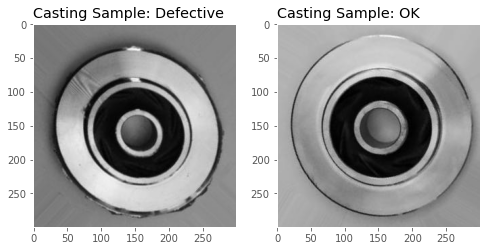

In [3]:
dir_train = '/content/casting_data/train'
dir_train_def = dir_train+'/def_front/' # Class label: Defective
dir_train_ok = dir_train+'/ok_front/' # Class label: OK
# Specify directory of test data
dir_test = '/content/casting_data/test'
dir_test_def = dir_test+'/def_front/'
dir_test_ok = dir_test+'/ok_front/'
# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok+os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

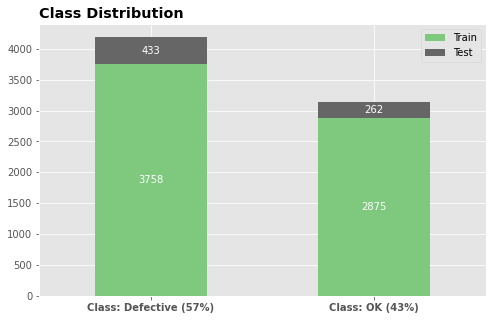

In [4]:
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

In [5]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 695 images belonging to 2 classes.


In [6]:
cnn_model = Sequential([ 
    # First block
    Conv2D(32, 3, activation='relu', padding='same', strides=2,
           input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    # Second block
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    # Flatenning
    Flatten(),
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')        # Only 1 output
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [7]:
n_epochs = 5
cnn_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=n_epochs,
    callbacks=ModelCheckpoint(
        'CNN_Casting_Inspection.hdf5',
        save_best_only=True,
        monitor='val_loss'),
    verbose=1)

Epoch 1/5
83/83 [==============================] - 97s 1s/step - loss: 0.6592 - accuracy: 0.6207 - val_loss: 0.5807 - val_accuracy: 0.6388
Epoch 2/5
83/83 [==============================] - 98s 1s/step - loss: 0.4733 - accuracy: 0.7750 - val_loss: 0.3725 - val_accuracy: 0.8303
Epoch 3/5
83/83 [==============================] - 96s 1s/step - loss: 0.3873 - accuracy: 0.8246 - val_loss: 0.3289 - val_accuracy: 0.8665
Epoch 4/5
83/83 [==============================] - 99s 1s/step - loss: 0.2848 - accuracy: 0.8837 - val_loss: 0.2395 - val_accuracy: 0.9125
Epoch 5/5
83/83 [==============================] - 103s 1s/step - loss: 0.2347 - accuracy: 0.9047 - val_loss: 0.2309 - val_accuracy: 0.9027


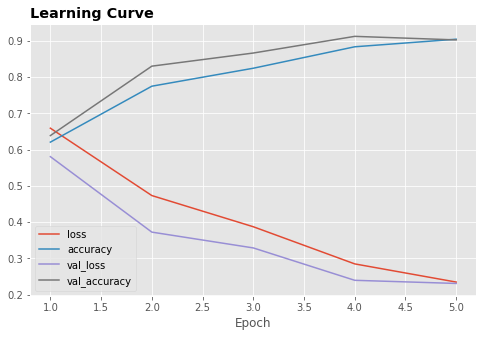

In [8]:
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

In [9]:
# Load saved model
best_model = load_model('./CNN_Casting_Inspection.hdf5')

# Make predictions on images in the test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

11/11 [==============================] - 4s 358ms/step


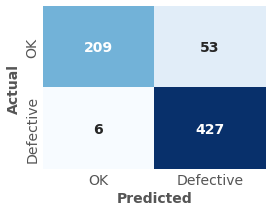

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [11]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9721    0.7977    0.8763       262
           1     0.8896    0.9861    0.9354       433

    accuracy                         0.9151       695
   macro avg     0.9308    0.8919    0.9058       695
weighted avg     0.9207    0.9151    0.9131       695



1/1 [==============================] - 0s 26ms/step


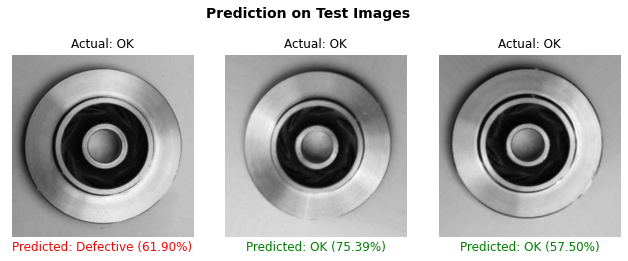

In [12]:
class_map = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 24ms/step


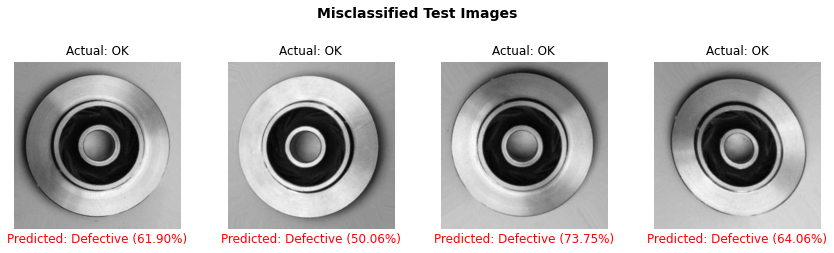

In [13]:
misclassified = np.nonzero(y_pred != y_true)[0]
batch_num = misclassified//batch_size
image_num = misclassified%batch_size

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Misclassified Test Images', y=0.98, weight='bold', size=14)
for ax, bnum, inum in zip(axes.flat, batch_num, image_num):
    images, labels = test_set[bnum]
    img = images[inum]
    ax.imshow(img.reshape(*img_size), cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[labels[inum]]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()